# 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助你：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(agent101)`，即可执行

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助你：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


# 🚀 LoRA 参数高效微调完整教程

## 📖 教程概述

本教程面向大模型技术初学者，通过一个完整的 SMS 垃圾短信分类任务，深入讲解 LoRA（Low-Rank Adaptation）参数高效微调技术的原理、实现和应用。

### 🎯 核心功能
- **数据准备**：自动下载并处理 SMS Spam 数据集，构建训练/验证/测试数据加载器
- **模型适配**：加载 GPT-2 预训练模型，将语言建模头替换为二分类头
- **LoRA 替换**：递归替换所有 Linear 层为 LoRA 层，冻结原始参数，仅训练 LoRA 参数
- **训练评估**：完整的训练流程，包含损失可视化、准确率评估和性能分析

### 🎓 学习目标
- **理解 LoRA 原理**：掌握低秩分解如何实现参数高效微调
- **实践微调流程**：从数据准备到模型部署的完整工作流
- **掌握关键超参**：rank、alpha 等参数的选择和调优策略
- **解决实际问题**：将通用语言模型适配为特定下游任务

### 📊 预期效果
- **参数效率**：仅训练少量 LoRA 参数（rank=16 时约数百万级），相比全量微调显著降低
- **性能提升**：3-5 个 epoch 即可将准确率从 45-50% 提升至 95%+
- **部署友好**：LoRA 增量参数体积小，便于分发和部署
- **初始一致性**：B 矩阵初始化为 0，确保替换后初始性能不变

### 💡 技术亮点
- **低秩分解**：ΔW ≈ A × B，其中 A ∈ ℝ^(d×r)，B ∈ ℝ^(r×k)，r << min(d,k)
- **参数冻结**：原始模型参数保持冻结，仅优化 LoRA 分支
- **增量更新**：前向传播为 `x(W + αAB)`，无需修改原始权重
- **灵活部署**：推理时动态叠加 LoRA 增量，支持多任务适配

> 💻 **环境要求**：建议在支持 CUDA 的 GPU 环境中执行，以获得最佳训练效果


In [ ]:
# 📦 环境依赖安装
# 
# 本教程需要以下核心依赖包，请根据您的环境选择合适的安装方式：
# - PyTorch：深度学习框架，支持 CPU/GPU 训练
# - tiktoken：GPT-2 分词器，用于文本预处理
# - pandas：数据处理，用于数据集操作
# - matplotlib：可视化，用于绘制训练曲线
# - numpy：数值计算基础库
print("🚀 LoRA 微调项目核心依赖一键安装")
print("=" * 50)

%pip install -U pip
%pip install -U "numpy>=1.26,<2.1" "pandas>=2.2.1" "matplotlib>=3.7.1" "tiktoken>=0.5.1"

# 🔧 PyTorch 安装（根据您的硬件环境选择）
# CPU 版本（适合轻量级实验）：
# %pip install "torch>=2.3.0" --index-url https://download.pytorch.org/whl/cpu

# GPU 版本（推荐，训练速度更快）：
# CUDA 12.1 版本（适用于大多数现代 GPU）
%pip install "torch>=2.3.0" --index-url https://download.pytorch.org/whl/cu121

# CUDA 11.8 版本（适用于较老的 GPU）
# %pip install "torch>=2.3.0" --index-url https://download.pytorch.org/whl/cu118

# 📚 安装配套工具库
# 提供 GPT-2 模型下载、权重加载等辅助功能
# %pip install -U git+https://github.com/rasbt/LLMs-from-scratch.git

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [14]:
# 🔍 环境版本检查
# 
# 检查关键依赖包的版本，确保满足教程要求
# 这有助于复现实验结果和排查环境问题

from importlib.metadata import version

# 核心依赖包及其版本要求
pkgs = [
    "numpy",      # 数值计算基础库，需 >=1.26,<2.1（兼容性要求）
    "pandas",     # 数据处理库，需 >=2.2.1（支持现代 DataFrame 操作）
    "matplotlib", # 可视化库，需 >=3.7.1（支持现代绘图功能）
    "tiktoken",   # GPT-2 分词器，需 >=0.5.1（支持 BPE 编码）
    "torch"       # PyTorch 深度学习框架，需 >=2.3.0（支持现代特性）
]

print("🔍 检查依赖包版本...")
for pkg in pkgs:
    try:
        pkg_version = version(pkg)
        print(f"✅ {pkg}: {pkg_version}")
    except Exception as e:
        print(f"❌ {pkg} 未安装: {e}")

print("\n💡 如果版本不满足要求，请重新运行上方的安装命令")

🔍 检查依赖包版本...
✅ numpy: 2.0.2
✅ pandas: 2.3.3
✅ matplotlib: 3.10.7
✅ tiktoken: 0.12.0
✅ torch: 2.8.0

💡 如果版本不满足要求，请重新运行上方的安装命令


## E.1 LoRA 简介（概念层）

- 传统微调：学习完整权重更新 ΔW，使得 `W_updated = W + ΔW`。
- LoRA：用更小的矩阵分解近似 ΔW，即 `ΔW ≈ A B`，因此 `W_updated = W + A B`。
- 前向时可写作 `x(W + AB) = xW + xAB`，无需改写原权重 W，AB 作为“增量分支”动态叠加。
- 超参数：
  - rank（秩）：控制 A、B 的内维度，决定新增可训练参数量与适配能力。
  - alpha：缩放系数，控制 LoRA 分支对原层输出的影响强度。
- 实践意义：只训练少量参数（A、B），显著降低显存与训练时间。


## 📊 数据集准备与预处理

### 🎯 数据集选择

我们使用经典的 **SMS Spam Collection** 数据集，这是一个公开的垃圾短信分类数据集，包含：
- **数据来源**：UCI Machine Learning Repository
- **数据规模**：约 5,572 条短信
- **标签分布**：ham（正常短信）vs spam（垃圾短信）
- **应用场景**：文本分类、垃圾信息过滤

### 🔧 数据预处理流程

1. **数据下载**：自动从 UCI 下载原始 TSV 文件
2. **标签映射**：将文本标签转换为数值（ham→0, spam→1）
3. **类别平衡**：确保训练集正负样本比例均衡
4. **数据划分**：按 7:2:1 比例分割为训练/验证/测试集
5. **序列处理**：使用 GPT-2 分词器进行文本编码和填充

### 📈 数据统计信息

- **训练集**：约 70% 的数据用于模型训练
- **验证集**：约 20% 的数据用于超参数调优和早停
- **测试集**：约 10% 的数据用于最终性能评估
- **序列长度**：根据训练集统计最长序列长度，确保一致性


In [46]:
# 📚 数据处理核心函数库
# 
# 本模块包含数据预处理、模型训练和评估的核心函数
# 为 LoRA 微调提供完整的数据流水线和训练工具

import os
from pathlib import Path
import requests
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import pandas as pd


def create_balanced_dataset(df):
    """
    创建类别平衡的数据集
    
    功能说明：
    - 统计垃圾短信数量，随机采样等量的正常短信
    - 确保训练时正负样本比例均衡，避免模型偏向多数类
    
    参数：
        df: 原始数据框，包含 Label 和 Text 列
        
    返回：
        balanced_df: 类别平衡后的数据框
    """
    # 统计垃圾短信数量
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # 随机采样等量的正常短信（固定随机种子确保可复现）
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # 合并正常短信子集和所有垃圾短信
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    
    return balanced_df


def random_split(df, train_frac, validation_frac):
    """
    随机划分数据集
    
    功能说明：
    - 按指定比例将数据划分为训练/验证/测试集
    - 使用固定随机种子确保结果可复现
    
    参数：
        df: 待划分的数据框
        train_frac: 训练集比例
        validation_frac: 验证集比例
        
    返回：
        train_df, validation_df, test_df: 三个数据框
    """
    # 随机打乱数据（固定随机种子）
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    # 计算划分索引
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    # 执行划分
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df


class SpamDataset(Dataset):
    """
    SMS 垃圾短信分类数据集类
    
    功能说明：
    - 继承 PyTorch Dataset，支持 DataLoader 批量加载
    - 自动处理文本分词、序列填充和标签转换
    - 支持动态序列长度或固定长度截断
    """
    
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        """
        初始化数据集
        
        参数：
            csv_file: CSV 文件路径
            tokenizer: 分词器对象（如 GPT-2 的 tiktoken）
            max_length: 最大序列长度，None 表示使用训练集最长长度
            pad_token_id: 填充 token 的 ID（GPT-2 默认为 50256）
        """
        self.data = pd.read_csv(csv_file)
        
        # 预分词：将文本转换为 token ID 序列
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        # 确定序列长度
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # 截断过长的序列
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        
        # 填充序列到统一长度
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        """获取单个样本"""
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),  # 输入序列
            torch.tensor(label, dtype=torch.long)     # 标签
        )
    
    def __len__(self):
        """返回数据集大小"""
        return len(self.data)
    
    def _longest_encoded_length(self):
        """计算最长编码序列长度"""
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    计算数据加载器的准确率
    
    功能说明：
    - 在指定设备上评估模型性能
    - 支持限制评估批次数以节省时间
    - 使用最后一个 token 的 logits 进行分类预测
    
    参数：
        data_loader: 数据加载器
        model: 待评估的模型
        device: 计算设备
        num_batches: 评估批次数，None 表示全部
        
    返回：
        accuracy: 准确率（0-1 之间）
    """
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            
            with torch.no_grad():
                # 使用最后一个 token 的 logits 进行分类
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    
    return correct_predictions / num_examples


def calc_loss_batch(input_batch, target_batch, model, device):
    """
    计算单个批次的损失
    
    参数：
        input_batch: 输入批次
        target_batch: 目标批次
        model: 模型
        device: 计算设备
        
    返回：
        loss: 交叉熵损失
    """
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    # 1. 运行模型，得到所有 token 的 logits: [B, T, C]
    full_logits = model(input_batch) 
    
    # 2. 仅切片获取序列中最后一个 token 的 logits，用于分类: [B, C]
    logits = full_logits[:, -1, :] 
    
    # 3. 使用 [B, C] 的 logits 和 [B] 的标签计算损失
    loss = torch.nn.functional.cross_entropy(logits, target_batch) 
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    计算数据加载器的平均损失
    
    参数：
        data_loader: 数据加载器
        model: 模型
        device: 计算设备
        num_batches: 评估批次数
        
    返回：
        average_loss: 平均损失
    """
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    评估模型在训练集和验证集上的损失
    
    参数：
        model: 待评估的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        device: 计算设备
        eval_iter: 评估批次数
        
    返回：
        train_loss, val_loss: 训练和验证损失
    """
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    """
    简化的分类器训练函数
    
    功能说明：
    - 执行完整的训练循环
    - 周期性评估模型性能
    - 记录训练过程中的损失和准确率
    
    参数：
        model: 待训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        optimizer: 优化器
        device: 计算设备
        num_epochs: 训练轮数
        eval_freq: 评估频率（步数）
        eval_iter: 每次评估的批次数
        
    返回：
        train_losses, val_losses, train_accs, val_accs, examples_seen: 训练记录
    """
    # 初始化记录列表
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    # 主训练循环
    for epoch in range(num_epochs):
        model.train()  # 设置为训练模式
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 清零梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            examples_seen += input_batch.shape[0]
            global_step += 1
            
            # 周期性评估
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        # 每个 epoch 后计算准确率
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    return train_losses, val_losses, train_accs, val_accs, examples_seen


def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    """
    绘制训练过程可视化图表
    
    功能说明：
    - 绘制训练和验证指标随时间和样本数的变化
    - 支持双 x 轴显示（epochs 和 examples）
    - 自动保存图表为 PDF 文件
    
    参数：
        epochs_seen: 已训练的轮数
        examples_seen: 已处理的样本数
        train_values: 训练集指标值
        val_values: 验证集指标值
        label: 指标名称（如 "loss", "accuracy"）
    """
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # 绘制训练和验证指标
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    # 创建第二个 x 轴显示样本数
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # 透明线用于对齐刻度
    ax2.set_xlabel("Examples seen")
    
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    """
    对单条文本进行分类预测
    
    功能说明：
    - 对输入的文本进行预处理和分词
    - 使用训练好的模型进行预测
    - 返回分类结果（spam 或 not spam）
    
    参数：
        text: 待分类的文本
        model: 训练好的模型
        tokenizer: 分词器
        device: 计算设备
        max_length: 最大序列长度
        pad_token_id: 填充 token ID
        
    返回：
        prediction: 分类结果字符串
    """
    model.eval()
    
    # 预处理输入文本
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    
    # 截断过长的序列
    input_ids = input_ids[:min(max_length, supported_context_length)]
    
    # 填充序列
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    
    # 模型推理
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 最后一个 token 的 logits
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    # 返回分类结果
    return "spam" if predicted_label == 1 else "not spam"

In [47]:
# 数据下载与拆分（与原书 ch06 逻辑一致）
# 步骤说明：
# 1) 下载并解压 SMS Spam 数据集；
# 2) 读取 TSV 文件为 DataFrame，并将标签 ham/spam 映射为 0/1；
# 3) 使用辅助函数做类别平衡与划分训练/验证/测试集；
# 4) 将划分结果保存为 CSV，方便后续 Dataset 加载。

import urllib
from pathlib import Path
import pandas as pd

data_file_path = "./sms_spam_collection/SMSSpamCollection.tsv"


# 读取、平衡、划分
# 原始文件为制表符分隔，列为 Label, Text

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
# 保证类别分布更均衡，避免训练时偏斜
balanced_df = create_balanced_dataset(df)
# 标签映射：ham->0, spam->1，便于后续计算损失
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# 按 7:2:1（训练:测试:验证）比例划分
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

# 落盘，便于复用与调试
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

print("数据已准备：train.csv / validation.csv / test.csv")


数据已准备：train.csv / validation.csv / test.csv


In [48]:
# 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

env: HF_ENDPOINT=https://hf-mirror.com
https://hf-mirror.com


In [49]:
# 构建 Dataset 与 DataLoader
# 说明：
# - 使用 GPT-2 的 BPE 分词器（tiktoken.get_encoding("gpt2")）。
# - 训练集初始化时不设 max_length（内部会统计训练集的最长长度），
#   将该长度传给验证/测试，以保证三者序列长度一致，避免评估偏差。

import torch
import tiktoken
from torch.utils.data import DataLoader

# 初始化 GPT-2 分词器
tokenizer = tiktoken.get_encoding("gpt2")
print("--- GPT-2 分词器信息 ---")
print(f"分词器名称: {tokenizer.name}")
print(f"词汇表大小 (总 Token 数): {tokenizer.max_token_value + 1}")
print(f"EOT (End-of-Text) Token ID: {tokenizer.eot_token}")

# 构建三份数据集；验证/测试共用训练集统计出的 max_length
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

# DataLoader 参数：
# - batch_size: 每批样本数；
# - shuffle: 训练集需打乱；
# - drop_last: 训练时丢弃最后不足一批的数据，便于批归一；
# - num_workers: 数据加载子进程数（Windows/笔记本环境可设 0）。
num_workers = 0
batch_size = 8

torch.manual_seed(123)  # 固定随机种子，保证结果可复现

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
print("--- 批次数 ---")
print(f"训练批次数: {len(train_loader)} | 验证批次数: {len(val_loader)} | 测试批次数: {len(test_loader)}")


--- GPT-2 分词器信息 ---
分词器名称: gpt2
词汇表大小 (总 Token 数): 50257
EOT (End-of-Text) Token ID: 50256
--- 批次数 ---
训练批次数: 130 | 验证批次数: 19 | 测试批次数: 38


## E.3 初始化 GPT-2 并改为分类任务

步骤：
1. 下载并加载 GPT-2 权重到自定义 `GPTModel`。
2. 将语言建模头替换为二分类头（输出维度=2）。
3. 验证加载是否正常：让模型生成一段文本观察输出是否通顺。
4. 查看未微调前的基线准确率。


In [50]:
class KVCache:
    def __init__(self, n_layers):
        self.cache = [None] * n_layers

    def get(self, layer_idx):
        return self.cache[layer_idx]

    def update(self, layer_idx, value):
        self.cache[layer_idx] = value

    def get_all(self):
        return self.cache

    def reset(self):
        for i in range(len(self.cache)):
            self.cache[i] = None

In [51]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import requests
import torch
from tqdm import tqdm


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())



def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()


def download_and_load_gpt2(model_size, models_dir):
    import tensorflow as tf

    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        response = requests.get(download_url, stream=True, timeout=60)
        response.raise_for_status()

        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size and file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return True

        block_size = 1024  # 1 KB
        desc = os.path.basename(download_url)
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=desc) as progress_bar:
            with open(destination, "wb") as file:
                for chunk in response.iter_content(chunk_size=block_size):
                    if chunk:
                        file.write(chunk)
                        progress_bar.update(len(chunk))
        return True

    try:
        if _attempt_download(url):
            return
    except requests.exceptions.RequestException:
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except requests.exceptions.RequestException:
                pass

        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    import tensorflow as tf

    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [52]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch
#
# This file collects all the relevant code that we covered thus far
# throughout Chapters 2-6.
# This file can be run as a standalone script.


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


#####################################
# Chapter 2
#####################################


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


#####################################
# Chapter 3
#####################################
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


#####################################
# Chapter 4
#####################################
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_resid(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) # logits 在 GPU 上

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


#####################################
# Chapter 5
#####################################
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

In [53]:
# 加载 GPT-2 预训练模型并改为分类任务
# 说明：
# - 使用项目提供的下载与装载函数，将公开的 GPT-2 预训练权重导入自定义 `GPTModel`。
# - 将原本的语言建模输出头替换为二分类头（输出维度=2）。
# - 通过一次简单文本生成做 sanity check，确认模型加载无误。
# - 评估 LoRA 前的基线准确率（少量批次抽样），作为对比基准。

# from gpt_download import download_and_load_gpt2
# from previous_chapters import GPTModel, load_weights_into_gpt
# from previous_chapters import (
#     generate_text_simple,
#     text_to_token_ids,
#     token_ids_to_text,
#     calc_accuracy_loader
# )

CHOOSE_MODEL = "gpt2-small (124M)"  # 可改为 medium/large/xl，但显存与下载时长会增加
BASE_CONFIG = {
    "vocab_size": 50257,     # GPT-2 词表大小
    "context_length": 1024,  # 最大上下文长度
    "drop_rate": 0.0,        # 先不加 dropout，便于对比
    "qkv_bias": True         # 注意力 QKV 是否使用 bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# 下载权重并装载到自定义 GPTModel
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

# 替换输出头为二分类头
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# 设备选择（优先使用 CUDA，其次 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 文本生成 sanity check（加载是否成功）
text_1 = "Every effort moves you"

# 1. 生成 token ID 张量（默认在 CPU 上）
input_ids_cpu = text_to_token_ids(text_1, tokenizer)
# 2. 🌟 关键修正：将输入张量移动到目标设备 (GPU/CUDA) 🌟
input_ids_device = input_ids_cpu.to(device)
# 3. 使用已在正确设备上的张量进行文本生成
ids = generate_text_simple(
    model=model,
    idx=input_ids_device,  # 使用已移动到 device 的张量
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"],
)
print(token_ids_to_text(ids, tokenizer))

# 文本生成 sanity check（加载是否成功）
# text_1 = "Every effort moves you"
# ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids(text_1, tokenizer),
#     max_new_tokens=15,
#     context_size=BASE_CONFIG["context_length"],
# )
# print(token_ids_to_text(ids, tokenizer))

# 未微调前的基线准确率（抽样评估 10 批）
torch.manual_seed(123)
print("评估未微调基线（各取 10 批）...")
train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_acc = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | Test: {test_acc*100:.2f}%")


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
Every effort moves you"""""""!""""""!
评估未微调基线（各取 10 批）...
Train: 46.25% | Val: 45.00% | Test: 48.75%


## E.4 LoRA 实现与全模型替换

我们实现两个类：
- `LoRALayer`：构造 A、B 两个矩阵，前向返回 `alpha * (x @ A @ B)`；B 初始化为 0，确保替换后初始输出不变。
- `LinearWithLoRA`：包装原 `Linear` 层，输出为 `linear(x) + lora(x)`。

并提供 `replace_linear_with_lora(model, rank, alpha)` 递归替换函数。


In [54]:
# 🔧 LoRA 核心实现：低秩适配层与模型替换
# 
# 本模块实现了 LoRA 的核心组件：
# 1. LoRALayer：低秩分解层，实现 ΔW ≈ A × B 的近似
# 2. LinearWithLoRA：包装原始线性层，叠加 LoRA 增量
# 3. replace_linear_with_lora：递归替换模型中的所有线性层

import math

class LoRALayer(torch.nn.Module):
    """
    LoRA 低秩适配层
    
    核心原理：
    - 用两个小矩阵 A、B 近似原始权重更新：ΔW ≈ A × B
    - A ∈ ℝ^(d×r)，B ∈ ℝ^(r×k)，其中 r << min(d,k)
    - 前向传播：y = α × (x @ A @ B)
    
    参数说明：
        in_dim: 输入维度（与原始 Linear 层一致）
        out_dim: 输出维度（与原始 Linear 层一致）
        rank: 低秩分解的秩，控制参数量和表达能力
        alpha: 缩放系数，平衡原始权重和 LoRA 增量的贡献
    
    初始化策略：
        - A 矩阵：使用 Kaiming Uniform 初始化，保持梯度稳定性
        - B 矩阵：初始化为 0，确保替换后初始输出不变
    """
    
    def __init__(self, in_dim: int, out_dim: int, rank: int, alpha: float):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播计算 LoRA 增量
        
        计算过程：
        1. x @ A：将输入投影到低维空间
        2. (x @ A) @ B：从低维空间投影到输出空间
        3. α × (x @ A @ B)：应用缩放系数
        
        返回：
            LoRA 增量输出，形状与原始线性层输出一致
        """
        return self.alpha * (x @ self.A @ self.B)


class LinearWithLoRA(torch.nn.Module):
    """
    带 LoRA 增量的线性层包装器
    
    功能说明：
    - 包装原始 Linear 层，在不修改原权重的前提下添加 LoRA 增量
    - 前向传播：output = original_linear(x) + lora_increment(x)
    - 训练时只优化 LoRA 参数，原始参数保持冻结
    
    设计优势：
    - 模块化：LoRA 增量可独立保存和加载
    - 灵活性：支持动态启用/禁用 LoRA 分支
    - 兼容性：与原始模型完全兼容
    """
    
    def __init__(self, linear: torch.nn.Linear, rank: int, alpha: float):
        """
        初始化包装器
        
        参数：
            linear: 原始线性层
            rank: LoRA 秩
            alpha: 缩放系数
        """
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播：原始输出 + LoRA 增量
        
        计算过程：
        1. 原始线性变换：y_orig = x @ W
        2. LoRA 增量：y_lora = α × (x @ A @ B)
        3. 最终输出：y = y_orig + y_lora
        
        返回：
            组合后的输出张量
        """
        return self.linear(x) + self.lora(x)


def replace_linear_with_lora(model: torch.nn.Module, rank: int, alpha: float):
    """
    递归替换模型中的所有 Linear 层为 LinearWithLoRA
    
    功能说明：
    - 深度遍历模型的所有子模块
    - 将 torch.nn.Linear 替换为 LinearWithLoRA
    - 保持模型结构不变，仅替换线性层
    
    参数：
        model: 待替换的模型
        rank: LoRA 秩
        alpha: 缩放系数
    
    注意事项：
    - 替换是就地进行的，会修改原始模型
    - 建议在替换前备份模型状态
    - 替换后需要重新设置优化器
    """
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # 替换为 LoRA 包装的线性层
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # 递归处理子模块
            replace_linear_with_lora(module, rank, alpha)


# 🔄 执行 LoRA 替换流程
print("🚀 开始 LoRA 模型替换...")

# 1. 统计替换前的可训练参数
print(f"📊 替换前可训练参数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 2. 冻结所有原始参数
for p in model.parameters():
    p.requires_grad = False
print(f"🔒 冻结后可训练参数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 3. 执行 LoRA 替换（关键超参数设置）
RANK = 16      # 低秩分解的秩，控制参数量和表达能力
ALPHA = 16     # 缩放系数，通常设置为 rank 的 1-2 倍
replace_linear_with_lora(model, rank=RANK, alpha=ALPHA)

# 4. 统计 LoRA 可训练参数
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🎯 LoRA 可训练参数: {trainable_params:,}")

# 5. 启用 LoRA 参数训练
for m in model.modules():
    if isinstance(m, LoRALayer):
        m.A.requires_grad = True
        m.B.requires_grad = True

# 🌟 在 LoRA 模块添加到模型后，再次将整个模型移动到目标设备 🌟
model.to(device)

print("✅ LoRA 替换与参数冻结设置完成！")
print(f"💡 参数效率提升：仅训练 {trainable_params:,} 个参数，相比全量微调大幅降低显存需求")


🚀 开始 LoRA 模型替换...
📊 替换前可训练参数: 124,441,346
🔒 冻结后可训练参数: 0
🎯 LoRA 可训练参数: 2,666,528
✅ LoRA 替换与参数冻结设置完成！
💡 参数效率提升：仅训练 2,666,528 个参数，相比全量微调大幅降低显存需求


In [55]:
# LoRA 替换后，验证基线应基本不变
# 原理：B 初始化为 0，LoRA 增量初始为 0，因此替换后但未训练前，性能应与替换前一致。

torch.manual_seed(123)
print("替换后、训练前的抽样准确率（各取 10 批）...")
train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_acc = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | Test: {test_acc*100:.2f}%")


替换后、训练前的抽样准确率（各取 10 批）...
Train: 46.25% | Val: 45.00% | Test: 48.75%


## 训练与评估

- 仅优化 LoRA 分支（A、B），原模型权重保持冻结。
- 学习率可从 5e-5 起步，epoch 取 3-5 做演示即可。
- 训练中周期性评估训练/验证损失与准确率，确认收敛趋势。


In [56]:
# 🚀 LoRA 微调训练流程
# 
# 本阶段执行 LoRA 参数的高效微调训练：
# 1. 设置优化器，仅优化 LoRA 参数
# 2. 执行训练循环，监控损失和准确率
# 3. 记录训练时间和性能指标

import time

# 🔧 优化器配置
# 仅优化需要梯度的参数（此时只包含 LoRA 的 A 和 B 矩阵）
optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad), 
    lr=5e-5,           # 学习率：LoRA 微调通常使用较小的学习率
    weight_decay=0.1   # 权重衰减：防止过拟合
)

# 📊 训练配置
num_epochs = 5        # 训练轮数：LoRA 微调通常收敛较快
eval_freq = 50        # 评估频率：每 50 步评估一次
eval_iter = 5         # 评估批次数：限制评估时间

print("🎯 开始 LoRA 微调训练...")
print(f"📋 训练配置：")
print(f"   - 训练轮数: {num_epochs}")
print(f"   - 学习率: {optimizer.param_groups[0]['lr']}")
print(f"   - 权重衰减: {optimizer.param_groups[0]['weight_decay']}")
print(f"   - 评估频率: 每 {eval_freq} 步")
print(f"   - 可训练参数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ⏱️ 记录训练开始时间
start_time = time.time()

# 🔄 执行训练循环
torch.manual_seed(123)  # 固定随机种子确保可复现
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
)

# ⏱️ 计算训练耗时
end_time = time.time()
training_time = (end_time - start_time) / 60

print(f"✅ 训练完成！")
print(f"⏱️ 训练耗时: {training_time:.2f} 分钟")
print(f"📈 最终训练准确率: {train_accs[-1]*100:.2f}%")
print(f"📈 最终验证准确率: {val_accs[-1]*100:.2f}%")


🎯 开始 LoRA 微调训练...
📋 训练配置：
   - 训练轮数: 5
   - 学习率: 5e-05
   - 权重衰减: 0.1
   - 评估频率: 每 50 步
   - 可训练参数: 2,666,528
Ep 1 (Step 000000): Train loss 2.865, Val loss 2.584
Ep 1 (Step 000050): Train loss 0.434, Val loss 0.390
Ep 1 (Step 000100): Train loss 0.084, Val loss 0.242
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 2 (Step 000150): Train loss 0.238, Val loss 0.036
Ep 2 (Step 000200): Train loss 0.092, Val loss 0.024
Ep 2 (Step 000250): Train loss 0.129, Val loss 0.086
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.289, Val loss 0.062
Ep 3 (Step 000350): Train loss 0.107, Val loss 0.029
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.005, Val loss 0.024
Ep 4 (Step 000450): Train loss 0.133, Val loss 0.173
Ep 4 (Step 000500): Train loss 0.016, Val loss 0.017
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.001, Val loss 0.013
Ep 5 (Step 000600): Train

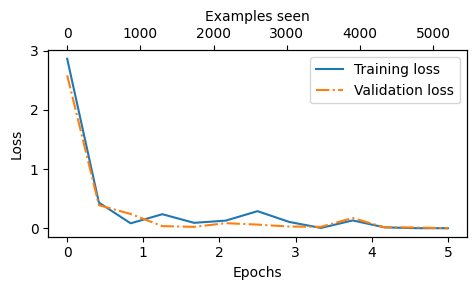

In [58]:
# 绘制训练/验证损失曲线（可选）

import torch

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")


In [59]:
# 全量评估（全数据集）

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Train: {train_accuracy*100:.2f}% | Val: {val_accuracy*100:.2f}% | Test: {test_accuracy*100:.2f}%")


Train: 100.00% | Val: 99.33% | Test: 96.67%


## 🎓 LoRA 微调最佳实践指南

### 🎯 何时使用 LoRA

**适用场景：**
- **大模型微调**：参数量超过 1B 的模型，全量微调成本过高
- **资源受限**：显存不足、训练时间有限的环境
- **多任务适配**：需要为同一基座模型适配多个下游任务
- **快速原型**：需要快速验证模型在特定任务上的表现

**不适用场景：**
- **小模型**：参数量 < 100M 的模型，全量微调可能更有效
- **数据充足**：拥有大量高质量标注数据，全量微调效果更好
- **计算资源充足**：有足够的显存和时间进行全量微调

### ⚙️ 超参数调优策略

#### Rank（秩）选择
- **小任务**：rank = 4-8，适合简单分类任务
- **中等任务**：rank = 16-32，适合大多数 NLP 任务
- **复杂任务**：rank = 64-128，适合需要强表达能力的任务
- **经验法则**：rank 越大，参数量越多，表达能力越强，但过拟合风险也越高

#### Alpha（缩放系数）设置
- **常用设置**：alpha = rank 或 alpha = 2×rank
- **调优策略**：
  - 从 alpha = rank 开始
  - 如果 LoRA 影响过小，增加 alpha
  - 如果训练不稳定，减少 alpha
- **经验范围**：alpha ∈ [rank/2, 2×rank]

#### 学习率配置
- **推荐范围**：1e-5 到 5e-4
- **LoRA 专用**：通常比全量微调使用更小的学习率
- **自适应调整**：根据训练稳定性动态调整

### 🔍 正确性验证

#### 替换后验证
```python
# 验证 LoRA 替换后初始性能不变
baseline_acc = evaluate_before_lora()
lora_acc = evaluate_after_lora_replacement()
assert abs(baseline_acc - lora_acc) < 0.01  # 误差应 < 1%
```

#### 训练过程监控
- **损失曲线**：训练损失应稳定下降，验证损失不应过度上升
- **准确率**：验证准确率应稳步提升，避免过拟合
- **梯度检查**：确保只有 LoRA 参数有梯度更新

### 🚀 性能优化技巧

#### 显存优化
- **梯度检查点**：在显存不足时启用
- **混合精度训练**：使用 FP16 减少显存占用
- **批次大小调整**：根据显存动态调整 batch_size

#### 训练加速
- **数据并行**：多 GPU 训练时使用
- **模型并行**：超大模型的分片训练
- **优化器选择**：AdamW 通常比 SGD 收敛更快

### 📊 常见问题与解决方案

#### 训练不收敛
- **检查学习率**：可能过大或过小
- **调整 rank**：增加表达能力
- **数据质量**：检查标注数据的准确性

#### 过拟合
- **减少 rank**：降低模型复杂度
- **增加正则化**：提高 weight_decay
- **早停策略**：监控验证损失，及时停止

#### 性能不佳
- **增加 rank**：提升模型表达能力
- **调整 alpha**：平衡原始权重和 LoRA 增量
- **数据增强**：增加训练数据的多样性

### 🔧 部署建议

#### 模型保存
- **分离保存**：基座模型和 LoRA 参数分别保存
- **版本管理**：为不同任务保存不同的 LoRA 适配器
- **压缩优化**：使用量化技术进一步减小文件大小

#### 推理优化
- **模型融合**：将 LoRA 参数合并到基座模型中
- **批处理**：批量处理多个请求提高效率
- **缓存策略**：缓存常用输入的处理结果

### 💡 进阶技巧

#### 多任务 LoRA
- **任务特定适配器**：为不同任务训练独立的 LoRA
- **任务切换**：运行时动态加载不同的 LoRA 适配器
- **参数共享**：在相关任务间共享部分 LoRA 参数

#### 持续学习
- **增量训练**：在新数据上继续训练现有 LoRA
- **灾难性遗忘**：使用正则化技术防止遗忘旧知识
- **知识蒸馏**：从大模型向小模型传递知识


## 保存与加载 LoRA 参数（Adapter）

- 保存：仅保存 LoRA 分支（A、B、alpha），体积小，便于分发与部署。
- 加载：在同样完成 LoRA 替换后，将保存的参数拷回对应 `LoRALayer` 中即可生效。


In [60]:
# 💾 LoRA 适配器保存与加载工具
# 
# 本模块提供 LoRA 参数的保存和加载功能：
# 1. 保存：仅保存 LoRA 增量参数，体积小，便于分发
# 2. 加载：在相同模型结构上恢复 LoRA 参数
# 3. 跨设备：支持在不同设备间传输 LoRA 参数

import torch
from typing import Dict, Tuple, Generator


def iter_lora_named_modules(model: torch.nn.Module) -> Generator[Tuple[str, LoRALayer], None, None]:
    """
    遍历模型中所有 LoRALayer 模块
    
    功能说明：
    - 深度遍历模型的所有子模块
    - 筛选出 LoRALayer 类型的模块
    - 返回模块的完整路径名和模块对象
    
    参数：
        model: 待遍历的模型
        
    返回：
        Generator: (模块全名, LoRALayer对象) 的生成器
    """
    for name, module in model.named_modules():
        if isinstance(module, LoRALayer):
            yield name, module


def save_lora_adapter(model: torch.nn.Module, filepath: str) -> None:
    """
    保存 LoRA 适配器参数
    
    功能说明：
    - 仅保存 LoRA 的 A、B 矩阵和 alpha 参数
    - 使用模块层级名作为键，避免加载时错位
    - 自动将参数移至 CPU，节省存储空间
    
    参数：
        model: 包含 LoRA 层的模型
        filepath: 保存路径
        
    保存内容：
        - {module_name}.A: LoRA A 矩阵
        - {module_name}.B: LoRA B 矩阵  
        - {module_name}.alpha: 缩放系数
    """
    state: Dict[str, torch.Tensor] = {}
    
    # 遍历所有 LoRA 层，收集参数
    for name, lora_module in iter_lora_named_modules(model):
        # 保存 A 矩阵（移至 CPU）
        state[f"{name}.A"] = lora_module.A.detach().cpu()
        # 保存 B 矩阵（移至 CPU）
        state[f"{name}.B"] = lora_module.B.detach().cpu()
        # 保存 alpha 参数（转换为张量便于跨设备）
        state[f"{name}.alpha"] = torch.tensor(lora_module.alpha)
    
    # 保存到文件
    torch.save(state, filepath)
    
    # 统计信息
    lora_layers = len([k for k in state if k.endswith('.A')])
    file_size = sum(tensor.numel() * tensor.element_size() for tensor in state.values())
    
    print(f"💾 LoRA 适配器已保存到: {filepath}")
    print(f"📊 包含 {lora_layers} 个 LoRA 层")
    print(f"📦 文件大小: {file_size / 1024 / 1024:.2f} MB")


def load_lora_adapter(model: torch.nn.Module, filepath: str, map_location: str = "cpu") -> None:
    """
    加载 LoRA 适配器参数
    
    功能说明：
    - 从文件加载 LoRA 参数到对应模块
    - 自动处理设备转换（CPU ↔ GPU）
    - 提供详细的加载状态反馈
    
    参数：
        model: 目标模型（必须包含相同结构的 LoRA 层）
        filepath: LoRA 参数文件路径
        map_location: 加载时的设备映射（"cpu" 或 "cuda"）
        
    注意事项：
    - 模型结构必须与保存时一致
    - 加载前需要先执行 LoRA 替换
    - 支持跨设备加载（自动转换到目标设备）
    """
    # 加载状态字典
    state = torch.load(filepath, map_location=map_location)
    
    restored, missing = 0, []
    
    # 遍历模型中的 LoRA 层，恢复参数
    for name, lora_module in iter_lora_named_modules(model):
        keyA, keyB, keyAlpha = f"{name}.A", f"{name}.B", f"{name}.alpha"
        
        # 检查所有必需的参数是否存在
        if keyA in state and keyB in state and keyAlpha in state:
            with torch.no_grad():
                # 恢复 A 矩阵（自动转换到目标设备）
                lora_module.A.copy_(state[keyA].to(lora_module.A.device))
                # 恢复 B 矩阵（自动转换到目标设备）
                lora_module.B.copy_(state[keyB].to(lora_module.B.device))
                # 恢复 alpha 参数
                lora_module.alpha = float(state[keyAlpha].item())
            restored += 1
        else:
            missing.append(name)
    
    # 输出加载结果
    print(f"🔄 LoRA 适配器加载完成")
    print(f"✅ 成功恢复 {restored} 个 LoRA 层")
    if missing:
        print(f"⚠️  缺失 {len(missing)} 个 LoRA 层: {missing[:3]}{'...' if len(missing)>3 else ''}")


# 🎯 示例：保存当前微调得到的 LoRA 参数
print("💾 保存 LoRA 适配器...")
save_lora_adapter(model, "lora_adapter.pt")

print("\n💡 使用说明：")
print("   - 保存的 LoRA 参数可以独立分发和部署")
print("   - 加载时需要先对模型执行相同的 LoRA 替换")
print("   - 支持在不同环境间迁移 LoRA 适配器")


💾 保存 LoRA 适配器...
💾 LoRA 适配器已保存到: lora_adapter.pt
📊 包含 73 个 LoRA 层
📦 文件大小: 10.17 MB

💡 使用说明：
   - 保存的 LoRA 参数可以独立分发和部署
   - 加载时需要先对模型执行相同的 LoRA 替换
   - 支持在不同环境间迁移 LoRA 适配器


## 推理示例（微调后）

- 以测试集样本作为演示，打印前若干条预测与真实标签。
- 注意：此处仅用于直观感受微调效果，完整指标请参考上方评估单元。


In [62]:
# 推理示例
# 说明：
# - 这里示范如何从 DataLoader 中取一个 batch，打印预测结果与真实标签对比。
# - 具体前向逻辑由 `train_classifier_simple`/`calc_accuracy_loader` 内部定义的模型调用保持一致。

import torch

# def predict_one_batch(data_loader, max_batches: int = 1):
#     model.eval()
#     shown = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             # 兼容 previous_chapters 内部的批数据结构
#             # 典型为 (input_ids, labels) 或字典；如结构不同，请参考库实现做相应适配
#             inputs, labels = batch[0].to(device), batch[1].to(device)
#             logits = model(inputs)
#             preds = torch.argmax(logits, dim=-1)
#             for i in range(min(5, inputs.shape[0])):
#                 print(f"样本{i}: 预测={int(preds[i].item())}, 真实={int(labels[i].item())}")
#             shown += 1
#             if shown >= max_batches:
#                 break

def predict_one_batch(data_loader, max_batches: int = 1):
    model.eval()
    shown = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            # 🌟 切片取最后一个 token 的 logits 🌟
            full_logits = model(inputs)
            # Logits 形状从 [B, T, C] 变为 [B, C]
            logits = full_logits[:, -1, :] 
            
            # 🌟 argmax 现在沿着正确的类别维度 -1 运行 🌟
            # preds 形状将是 [B]，其中 B 是批次大小（例如 8）
            preds = torch.argmax(logits, dim=-1)
            
            # 标签 (labels) 已经是 [B] 形状，不需要修改
            
            for i in range(min(5, inputs.shape[0])):
                # 现在 preds[i] 是一个形状为 [] 的标量张量，可以安全地使用 .item()
                print(f"样本{i}: 预测={int(preds[i].item())}, 真实={int(labels[i].item())}")
            shown += 1
            if shown >= max_batches:
                break

predict_one_batch(test_loader, max_batches=1)


样本0: 预测=1, 真实=1
样本1: 预测=1, 真实=1
样本2: 预测=1, 真实=1
样本3: 预测=0, 真实=0
样本4: 预测=1, 真实=1


## 🎉 LoRA 微调教程总结

### 🏆 核心收获

通过本教程，您已经掌握了：

1. **LoRA 原理理解**：深入理解低秩分解如何实现参数高效微调
2. **完整实现流程**：从数据准备到模型部署的端到端工作流
3. **关键超参调优**：掌握 rank、alpha 等参数的选择和调优策略
4. **实践技能提升**：具备独立进行 LoRA 微调的能力

### 📊 技术优势总结

#### 参数效率
- **显著降低**：可训练参数从 O(dk) 降低到 O(r(d+k))
- **显存友好**：大幅减少训练时的显存需求
- **训练加速**：减少参数更新，提升训练速度

#### 部署灵活性
- **模块化设计**：LoRA 增量可独立保存和加载
- **多任务支持**：同一基座模型可适配多个下游任务
- **版本管理**：便于管理不同任务的适配器

#### 性能保证
- **初始一致性**：B 矩阵初始化为 0，确保替换后输出不变
- **收敛稳定**：LoRA 微调通常比全量微调更稳定
- **效果相当**：在大多数任务上达到与全量微调相近的效果

### 🚀 下一步学习建议

#### 进阶技术
- **QLoRA**：结合量化的 LoRA，进一步降低显存需求
- **AdaLoRA**：自适应调整不同层的 rank
- **LoRA+**：改进的 LoRA 变体，提升表达能力

#### 工程实践
- **HuggingFace 集成**：使用 `peft` 库进行 LoRA 微调
- **分布式训练**：多 GPU/多节点的大规模训练
- **生产部署**：模型服务化和性能优化

#### 应用拓展
- **多模态 LoRA**：在视觉-语言模型中的应用
- **领域适配**：特定领域的 LoRA 微调
- **持续学习**：增量学习和知识保持

### 💡 关键要点回顾

1. **选择合适场景**：大模型、资源受限、多任务适配时优先考虑 LoRA
2. **超参调优**：从 rank=16, alpha=16 开始，根据任务复杂度调整
3. **正确性验证**：确保 LoRA 替换后初始性能不变
4. **性能监控**：密切关注训练过程中的损失和准确率变化
5. **部署优化**：合理保存和加载 LoRA 适配器

### 🔗 相关资源

- **论文原文**：[LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)
- **HuggingFace PEFT**：[Parameter-Efficient Fine-Tuning](https://huggingface.co/docs/peft/)
- **实践案例**：更多 LoRA 微调的实际应用案例
- **社区支持**：加入相关技术社区，获取最新进展

---

**🎯 恭喜您完成了 LoRA 微调的完整学习！** 现在您已经具备了使用 LoRA 进行大模型微调的能力，可以开始在实际项目中应用这些技术了。记住，实践是最好的学习方式，建议您尝试在不同的数据集和任务上应用 LoRA 微调技术。
